In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
from sklearn.preprocessing import MinMaxScaler

from warnings import filterwarnings
filterwarnings('ignore')

# Load the Titanic dataset
titanic_df = pd.read_csv('./train.csv')

In [2]:
# Drop columns that are not useful for prediction
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1)

In [3]:
titanic_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')

In [4]:
# Define features and target variable
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']

In [5]:
# Handle missing values
X['Age'].fillna(X['Age'].median(), inplace=True)
X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)

In [6]:
# Convert categorical variables to numerical
encoder = LabelEncoder()
X['Sex'] = encoder.fit_transform(X['Sex'])
X['Embarked'] = encoder.fit_transform(X['Embarked'])
X['Ticket'] = encoder.fit_transform(X['Ticket'])

In [7]:
numeric_cols = X.select_dtypes(np.number).columns.to_list()

scaler = MinMaxScaler()

scaler.fit(X[numeric_cols])

X[numeric_cols] = scaler.transform(X[numeric_cols])

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

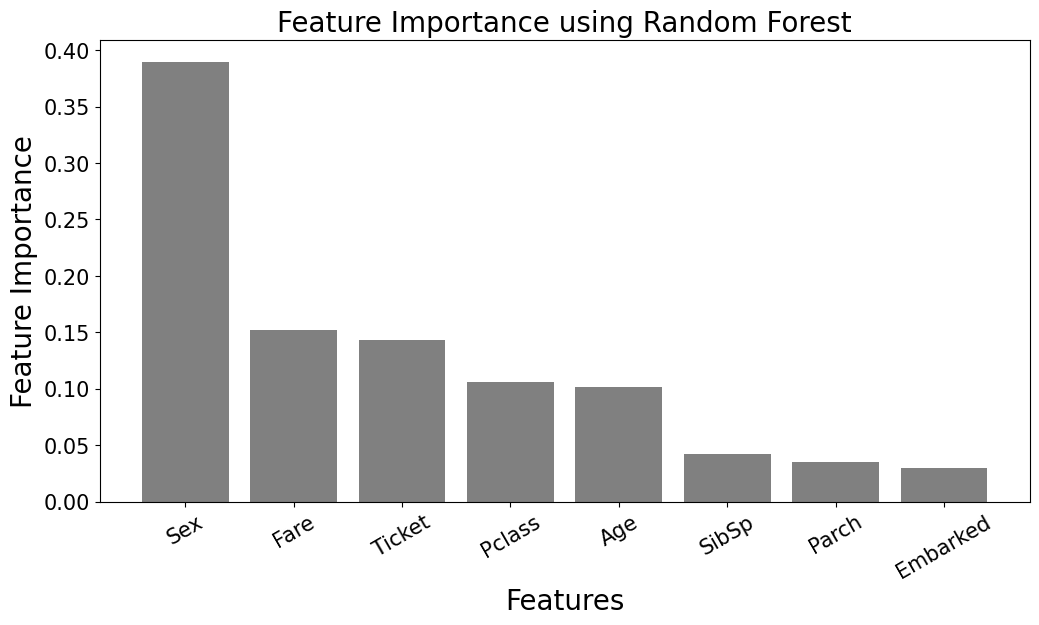

In [9]:
# Train Random Forest classifier

rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

rf_classifier = RandomForestClassifier(n_estimators=500, random_state=1, min_samples_leaf=2, max_depth=6,warm_start=True, \
                                       verbose=0)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

weighhh_df = pd.DataFrame({
    'features': X.columns,
    'weights': feature_importances
})

weighhh_df.sort_values(['weights'], ascending=False,inplace=True)

#Plot relative feature importance
plt.figure(figsize=(12, 6))
plt.bar(weighhh_df['features'], weighhh_df['weights'], color='gray')
plt.xlabel('Features', fontsize=20)
plt.ylabel('Feature Importance', fontsize=20)
plt.title('Feature Importance using Random Forest', fontsize=20)
# plt.gca().invert_yaxis()
plt.savefig('rf.png')
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
plt.show()


In [10]:
feats = weighhh_df['features'].unique()
feats

array(['Sex', 'Fare', 'Ticket', 'Pclass', 'Age', 'PassengerId', 'SibSp',
       'Parch', 'Embarked'], dtype=object)

In [13]:
importances = rf_classifier.feature_importances_

In [20]:
nums = []
thresholds = []
accuracies = []
for i in range(len(importances)):
    selected_feats = SelectFromModel(rf_classifier, threshold=importances[i], prefit=True)
    transformed_X = selected_feats.transform(X_train)
    model = RandomForestClassifier(random_state=42).fit(transformed_X, y_train)
    transformed_X_test = selected_feats.transform(X_test)
    accuracy = accuracy_score(y_test, model.predict(transformed_X_test))
    print(f"threshold value = {(importances[i]): <15}; no. featues = {transformed_X.shape[1]}; accuracy = {accuracy}")
    nums.append(transformed_X.shape[1])
    thresholds.append(importances[i])
    accuracies.append(accuracy)

threshold value = 0.10621798416028955; no. featues = 4; accuracy = 0.8156424581005587
threshold value = 0.3897640147126443; no. featues = 1; accuracy = 0.7821229050279329
threshold value = 0.10161095220633014; no. featues = 5; accuracy = 0.8268156424581006
threshold value = 0.041928537884974915; no. featues = 6; accuracy = 0.8212290502793296
threshold value = 0.03523085065310269; no. featues = 7; accuracy = 0.8324022346368715
threshold value = 0.14299059087187213; no. featues = 3; accuracy = 0.8435754189944135
threshold value = 0.15198834603017553; no. featues = 2; accuracy = 0.7988826815642458
threshold value = 0.030268723480610854; no. featues = 8; accuracy = 0.8268156424581006


In [21]:
optimal_threshold = thresholds[np.argmax(accuracies)]
optimal_num_of_feats = nums[np.argmax(accuracies)]
print(f"Best accuracy: {np.max(accuracies)};\noptimal number of features: {optimal_num_of_feats};\nOptimal threshold: {optimal_threshold}")

Best accuracy: 0.8435754189944135;
optimal number of features: 3;
Optimal threshold: 0.14299059087187213


In [23]:
optimal_selects = SelectFromModel(rf_classifier, threshold=optimal_threshold, prefit=True)
act_model = RandomForestClassifier(random_state=42).fit(optimal_selects.transform(X_train), y_train)
feats_index = optimal_selects.get_support()
selected_cols = X_train.columns[feats_index]
print(f"Selected features: {selected_cols}")

Selected features: Index(['Sex', 'Ticket', 'Fare'], dtype='object')


Predicting the accuracy of the model on the training set

In [24]:
accuracy_score(y_train, act_model.predict(optimal_selects.transform(X_train)))

0.9845505617977528

Predicting the accuracy of the model on the test set

In [25]:
accuracy_score(y_test, act_model.predict(optimal_selects.transform(X_test)))

0.8435754189944135